<a href="https://colab.research.google.com/github/fwahl711/glassstepcount/blob/main/stepcounting_slides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computergestütze Analyse von Sensordaten
## Beispiel: Schrittzähler aus Smartglass Daten
Dr. Florian Wahl

## Schritt 1: Vorbereitung
1. Daten herunterladen
2. Pakete laden
3. Daten einlesen

In [1]:
!wget https://raw.githubusercontent.com/fwahl711/glassstepcount/main/data.csv

--2021-08-02 12:23:03--  https://raw.githubusercontent.com/fwahl711/glassstepcount/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36223 (35K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  35.37K  --.-KB/s    in 0.002s  

2021-08-02 12:23:03 (17.9 MB/s) - ‘data.csv’ saved [36223/36223]



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Plot Konfiguration
plt.rcParams['figure.figsize'] = (16, 9)
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("data.csv")
df = df.drop("Unnamed: 0", axis=1)
df.index /= 50  # Umrechnung der Zeitachse von Samples auf Sekunden

## Schritt 2: Rohdaten sichten 
1. Vorhandene Daten anzeigen
2. Eine Accelerometerachse auswählen

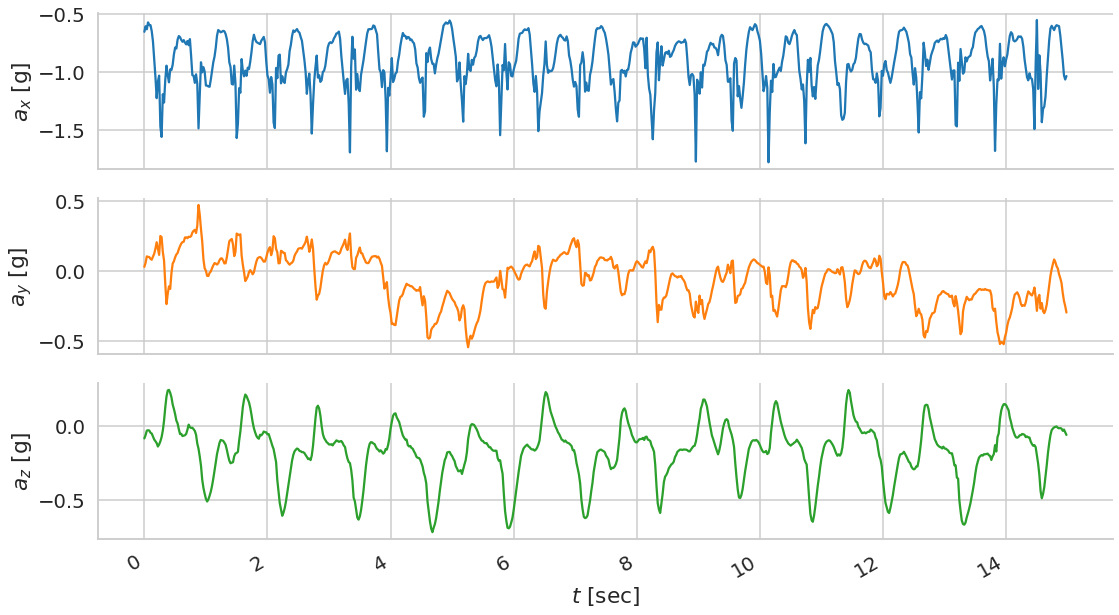

In [4]:
ax = df.plot(subplots=True, legend=False)
ax[2].set_xlabel("$t$ [sec]")
ax[0].set_ylabel("$a_x$ [g]")
ax[1].set_ylabel("$a_y$ [g]")
ax[2].set_ylabel("$a_z$ [g]")
sns.despine()
plt.tight_layout()

plt.savefig("alldata.png", dpi=300)

Wir wählen die Beschleunigung auf der x-Achse für unser weiteres Vorgehen aus. Hier finden wir ca. 2 Tiefpunkte pro Sekunde, was einem normalen Gehtempo entspricht (zum Vergleich, siehe Video).

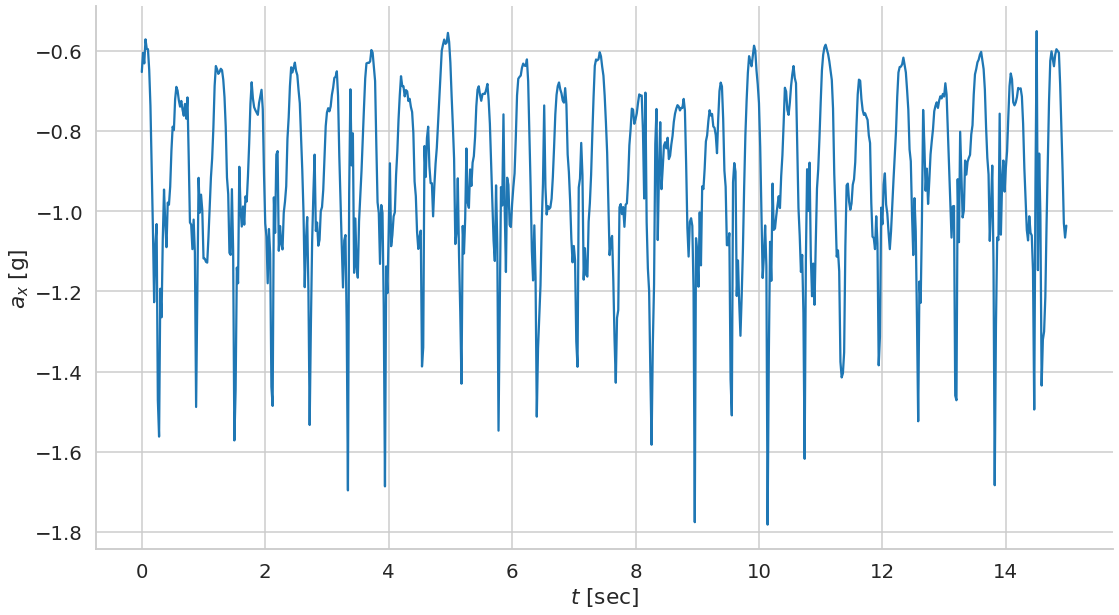

In [6]:
plt.figure()

acc_x = df["accelX"]
ax = acc_x.plot()
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
sns.despine()
plt.tight_layout()

plt.savefig("alldata.png", dpi=300)

## Schritt 3: Aufbereitung der Daten
1. Berechnung der Ableitung
2. Verschiebung der Ableitung
3. Finden der Tiefpunkte
4. Ergebnis anzeigen

In [ ]:
data = pd.DataFrame(acc_x.rename("ax"))
data.head()

,ax
0.00,-0.652344
0.02,-0.604492
0.04,-0.630859
0.06,-0.570801
0.08,-0.594238


In [ ]:
data["dax"] = data.ax.diff()
data.head()

,ax,dax
0.00,-0.652344,NaN
0.02,-0.604492,0.047852
0.04,-0.630859,-0.026367
0.06,-0.570801,0.060059
0.08,-0.594238,-0.023438


In [ ]:
data["dax_shift"] = data.dax.shift(-1)
data.head()

,ax,dax,dax_shift
0.00,-0.652344,NaN,0.047852
0.02,-0.604492,0.047852,-0.026367
0.04,-0.630859,-0.026367,0.060059
0.06,-0.570801,0.060059,-0.023438
0.08,-0.594238,-0.023438,-0.001221


In [ ]:
data["valleys"] = (data.dax < 0) & (data.dax_shift >= 0)
data.head()

,ax,dax,dax_shift,valleys
0.00,-0.652344,NaN,0.047852,False
0.02,-0.604492,0.047852,-0.026367,False
0.04,-0.630859,-0.026367,0.060059,True
0.06,-0.570801,0.060059,-0.023438,False
0.08,-0.594238,-0.023438,-0.001221,False


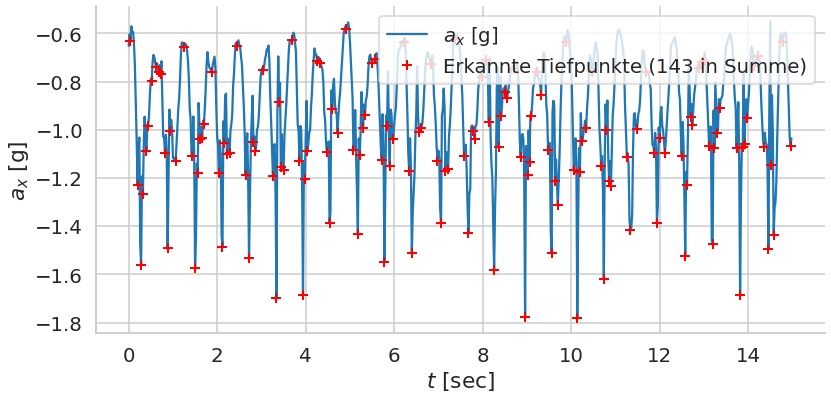

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Tiefpunkte ({data.valleys.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()



## Schritt 4: Verfeinern der Regel
Hinzufügen einer 3. Bedingung um Falsch-Positive loszuwerden. Hierbei Berücksichtigung des absoluten Werts.

In [ ]:
data.ax.describe()

count    750.000000
mean      -0.910960
std        0.223554
min       -1.782227
25%       -1.049622
50%       -0.895142
75%       -0.724426
max       -0.550293
Name: ax, dtype: float64

In [ ]:
limit = data.ax.mean() - 2*data.ax.std()
data["valleys_limit"] = (data.ax < limit) & data.valleys

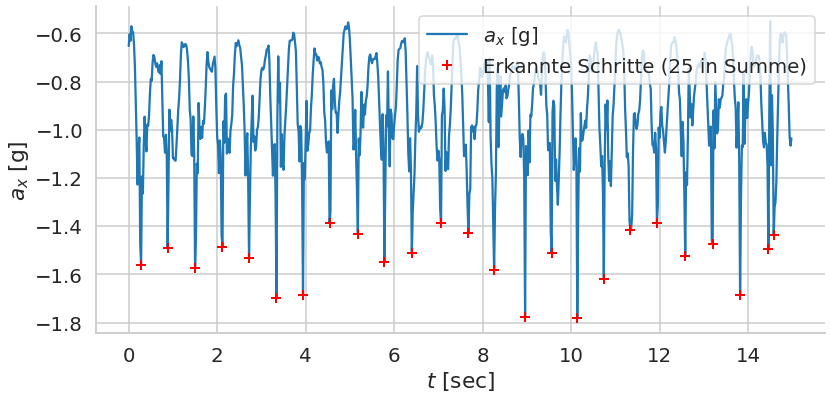

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys_limit"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Schritte ({data.valleys_limit.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

## Schritt 5: Weitere Verfeinerung
Minimalabstand zwischen Schritten einfügen.

In [ ]:
max_steps_per_sec = 5

data["valleys_time_diff"] = pd.Series(data.index[data["valleys_limit"]].values, index=data.index[data["valleys_limit"]].values).diff().fillna(np.inf)
data["valleys_timediff_limited"] = data["valleys_limit"] & (data["valleys_time_diff"] > (1/max_steps_per_sec))

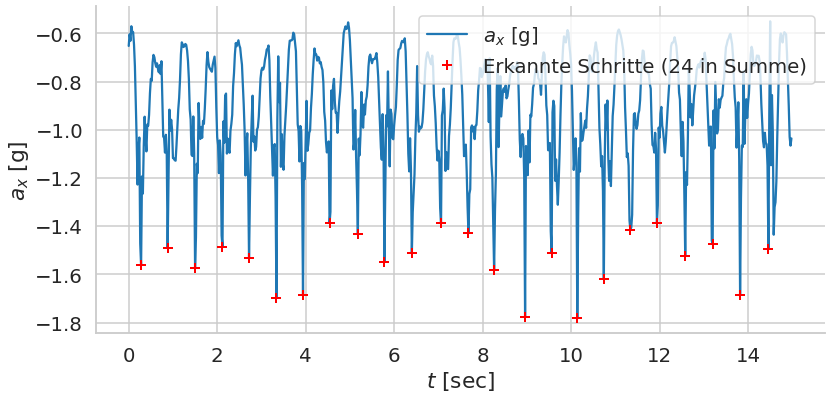

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys_timediff_corrected"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Schritte ({data.valleys_timediff_corrected.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Tiefpunkte ({data.valleys.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_z$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

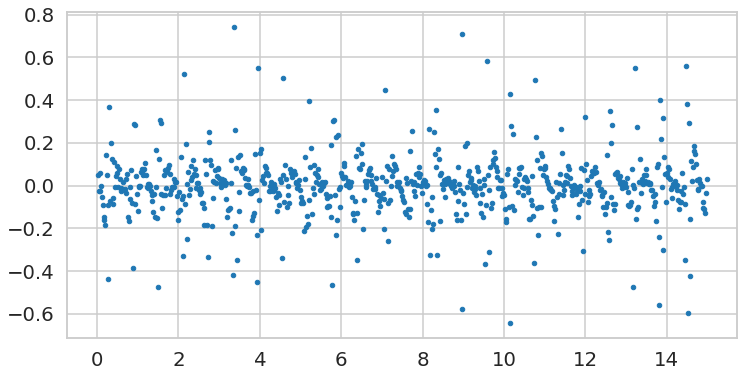

In [ ]:
dax.plot(style=".")

In [ ]:
dax = dax.fillna(np.inf)
dax.head()

0.00         inf
0.02    0.047852
0.04   -0.026367
0.06    0.060059
0.08   -0.023438
Name: accelX, dtype: float64

In [ ]:
dax_shifted = daz.shift(-1)
dax_shifted.head()

0.00    0.047852
0.02   -0.026367
0.04    0.060059
0.06   -0.023438
0.08   -0.001221
Name: accelX, dtype: float64

In [ ]:
data = pd.DataFrame(az.rename("ax"))
data["dax"] = dax
data["dax_shifted"] = dax_shifted

<Figure size 864x432 with 0 Axes>

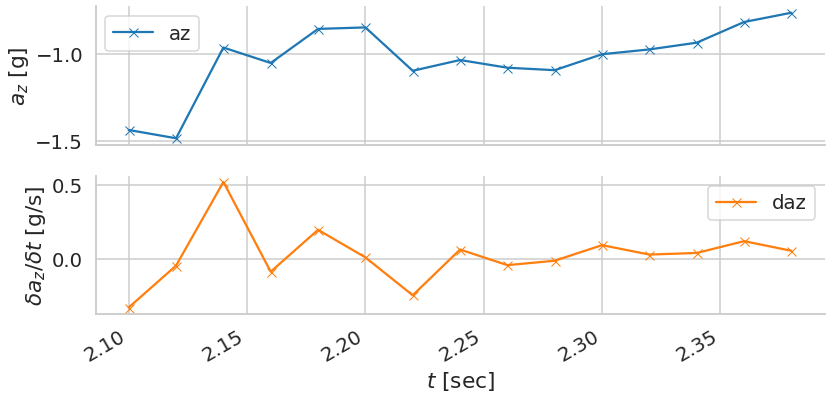

In [ ]:
plt.figure()
ax = data.iloc[105:120][["a", "daz"]].plot(subplots=True, style="-bx")
ax[1].set_xlabel("$t$ [sec]")
ax[0].set_ylabel(r"$a_z$ [g]")
ax[1].set_ylabel(r"$\delta{} a_z / \delta{} t$ [g/s]")
sns.despine()
plt.tight_layout()


In [ ]:
data.head()

,az,daz,daz_shifted
0.00,-0.652344,inf,0.047852
0.02,-0.604492,0.047852,-0.026367
0.04,-0.630859,-0.026367,0.060059
0.06,-0.570801,0.060059,-0.023438
0.08,-0.594238,-0.023438,-0.001221


In [ ]:
data["valleys"] = (data.daz < 0) & (data.daz_shifted >= 0)

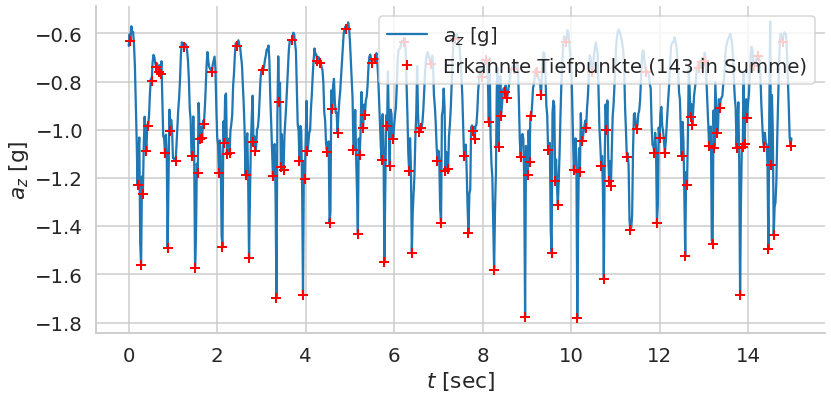

In [ ]:
plt.figure()
ax = data.az.plot(label="$a_z$ [g]")
ax.plot(data[data["valleys"]].az, "r+", markersize=10, mew=2, label=f"Erkannte Tiefpunkte ({data.valleys.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_z$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

In [ ]:
data.az.describe()

count    750.000000
mean      -0.910960
std        0.223554
min       -1.782227
25%       -1.049622
50%       -0.895142
75%       -0.724426
max       -0.550293
Name: az, dtype: float64

In [ ]:
limit = data.az.mean() - 2*data.az.std()
data["select_valleys"] = (data.az < limit) & data.valleys

In [ ]:
data[data["select_valleys"]]

,az,daz,daz_shifted,valleys,select_valleys
0.28,-1.562500,-0.091309,0.369141,True,True
0.88,-1.488525,-0.385010,0.288330,True,True
1.50,-1.572021,-0.473877,0.125488,True,True
2.12,-1.485840,-0.047607,0.520508,True,True
2.72,-1.533447,-0.332275,0.251709,True,True
3.34,-1.696777,-0.416504,0.741699,True,True
3.94,-1.686768,-0.449463,0.549072,True,True
4.54,-1.387451,-0.339111,0.047363,True,True
5.18,-1.430420,-0.179199,0.393799,True,True
5.78,-1.547607,-0.465332,0.303711,True,True


In [ ]:
limit

-1.3580668922769144

In [ ]:
data.select_valleys.sum()

25

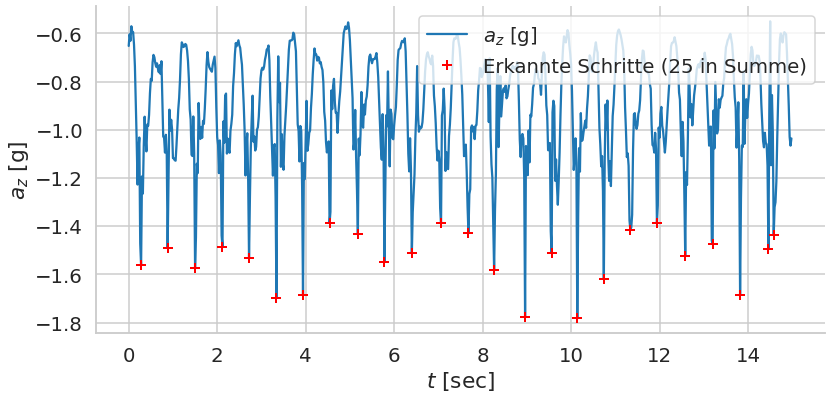

In [ ]:
plt.figure()
ax = data.az.plot(label="$a_z$ [g]")
ax.plot(data[data["select_valleys"]].az, "r+", markersize=10, mew=2, label=f"Erkannte Schritte ({data.select_valleys.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_z$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

In [ ]:
pd.Series(data.index[data.select_valleys].values).diff()

0      NaN
1     0.60
2     0.62
3     0.62
4     0.60
5     0.62
6     0.60
7     0.60
8     0.64
9     0.60
10    0.62
11    0.66
12    0.62
13    0.58
14    0.70
15    0.60
16    0.58
17    0.60
18    0.60
19    0.60
20    0.64
21    0.62
22    0.62
23    0.64
24    0.12
dtype: float64